# Kepler-452 

(May not be real, see: https://ui.adsabs.harvard.edu/abs/2018AJ....155..210M/abstract)

In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

planets = Table.read('../../planets2.txt', format='csv', comment='#')
K452b = planets[planets['pl_name'] == 'Kepler-452 b'][0]
print(K452b['pl_name', 'sy_jmag', 'st_teff', 'pl_rade'])

  pl_name    sy_jmag st_teff pl_rade
------------ ------- ------- -------
Kepler-452 b  12.263  5757.0    1.63


### Compute the probabilistic mass using Kipping & Chen: 

https://iopscience.iop.org/article/10.3847/1538-4357/834/1/17

In [2]:
import sys
sys.path.append('/Users/tgordon/research/exomoons/forecaster')
import mr_forecast as mr

res = mr.Rstat2M(mean=K452b['pl_radj'], std=K452b['pl_radjerr1'], unit='Jupiter', sample_size=1000, grid_size=200)
print(res)

(0.01110982818246437, 0.009640930297649139, 0.0045089485287044965)


### Compute the hill sphere

In [7]:
mj_ms = 0.0009543
hill = lambda mp, ms, a, e: a * (1 - e) * (mp * mj_ms/(3*ms)) ** (1./3.)

a = 1.046, 1.046 + 0.019, 1.046 - 0.015
e = 0.036, 0.0, 0.85
likely_hill = hill(res[0], K452b['st_mass'], a[0], e[0])
pessimistic_hill = hill(res[0]-res[1], 1.11-0.09, a[1], e[2])
optimistic_hill = hill(res[0]+res[1], 1.11+0.15, a[2], e[1])
print(likely_hill, " ", pessimistic_hill, " ", optimistic_hill)

0.015159606993109453   0.0012314758545961372   0.017906101082803334


### Look at the light curve to assess variability and rotation:

In [9]:
import lightkurve as lk
lcfs = lk.search_lightcurvefile('Kepler-452', mission='Kepler').download_all()
lc = lcfs.PDCSAP_FLUX.stitch()

/usr/local/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


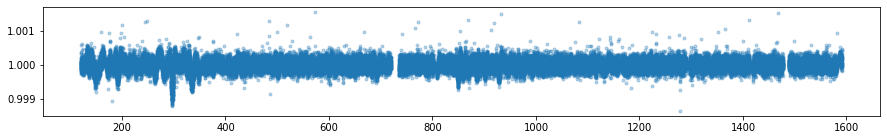

In [10]:
clipped_lc = lc.remove_outliers(sigma=10)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_lc.flux, '.', alpha=0.3)

### Compute the power spectrum of the combined Kepler light curve

(1, 10000.0)

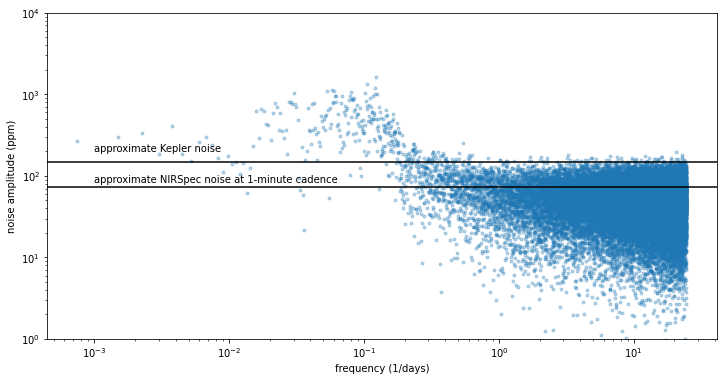

In [12]:
f = np.fft.rfftfreq(len(clipped_lc.flux), clipped_lc.time[1] - clipped_lc.time[0])
fft = np.fft.rfft(clipped_lc.flux)
fft = fft*np.conj(fft)
powerfft = fft.real / len(clipped_lc.time)**2
ampfft = np.sqrt(powerfft * (60 * 60 * 24) / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, ampfft, '.', alpha=0.3)

pl.axhline(150, color='k')
pl.axhline(73.6, color='k')
pl.annotate(s='approximate Kepler noise', xy=(1e-3, 200))
pl.annotate(s='approximate NIRSpec noise at 1-minute cadence', xy=(1e-3, 82))

pl.ylabel("noise amplitude (ppm)")
pl.xlabel("frequency (1/days)")

pl.ylim(1, 1e4)

References: 

Discovery: https://ui.adsabs.harvard.edu/abs/2015AJ....150...56J/abstract